In this notebook, I consider the 5-core dataset of reviews for movies and TV on Amazon, in which all users and items have at least 5 reviews. The dataset can be downloaded at this [website](http://jmcauley.ucsd.edu/data/amazon/). The task is to predict the ratings. Two different types of model can be exploited for this kind of dataset. The first type is collabrative filtering based on the reviewer-item rating matrix. The second is a classifier based purely on the review text content. I will first try both methods independently, and then check if combination of two methods can lead to better performance.

# I. Data Aquisition

First download the *reviews_Movies_and_TV_5.json.gz* file from the [website](http://jmcauley.ucsd.edu/data/amazon/). Then use the following code to read into a dataframe.

In [3]:
import numpy as np
import pandas as pd
import gzip


def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Movies_and_TV_5.json.gz')
# df.to_csv("reviews_Movies_and_TV_5.csv") # write to disk for future use
# df2 = pd.read_csv('shuffled_reviews_Movies_and_TV_5.csv', index_col=0)

I will use 70% of the entire dataset as training set, 20% as cross validation (CV) set, and 10% as test set.

In [5]:
numOfReviews = len(df)

N_train = numOfReviews*7/10
N_cv = numOfReviews*2/10
N_test = numOfReviews - N_train - N_cv

# II. Biased Matrix Factorization (MF) Based on Reviewer-Item Rating Matrix

I use the [MyMediaLite](http://www.mymedialite.net/) software to build the biased matrix factorization model. A good introduction to biased matrix factorization can be found at this [site](http://activisiongamescience.github.io/2016/01/11/Implicit-Recommender-Systems-Biased-Matrix-Factorization/).
In the following, I first randomly shuffle the original data, extract the userId, productId, and ratings to form the dataframe **ratings**. I then divide the ratings dataframe into training, cross validation and test set, and save them as csv file to feed for the MyMediaLite software. 

In [6]:
df2 = df.sample(frac = 1) # random shuffle
del df
# df2.to_csv("shuffled_reviews_Movies_and_TV_5.csv")

ratings = df2[['reviewerID', 'asin', 'overall']]
ratings.iloc[0 : N_train, :].to_csv("ratings_Movies_and_TV_5_train.csv", index = False, header = False)

ratings_cv = ratings.iloc[N_train : N_train + N_cv, :]
ratings_cv.index = range(0, len(ratings_cv))
ratings_cv.to_csv("ratings_Movies_and_TV_5_cv.csv", index = False, header = False)

ratings_test = ratings.iloc[-N_test :, :]
ratings_test.index = range(0, len(ratings_test))
ratings_test.to_csv("ratings_Movies_and_TV_5_test.csv", index = False, header = False)

[Download](http://www.mymedialite.net/download/index.html) the MyMediaLite binary package and use the following command to train biased MF model and make prediction on validation set and test set repectively:

```
./rating_prediction --recommender=BiasedMatrixFactorization --recommender-options="num_factors=20 bias_reg=0.001" --training-file=ratings_Movies_and_TV_5_train.csv --test-file=ratings_Movies_and_TV_5_cv.csv --prediction-file=prediction_cv.csv

./rating_prediction --recommender=BiasedMatrixFactorization --recommender-options="num_factors=20 bias_reg=0.001" --training-file=ratings_Movies_and_TV_5_train.csv --test-file=ratings_Movies_and_TV_5_test.csv --prediction-file=prediction_test.csv

```
The above command produces prediction files "prediction_cv.csv" and "prediction_test.csv" for the validation set and test set respectively. We read the "prediction_cv.csv" file and calculate the root mean square error (RMSE) and accuracy for validation set.

In [7]:
MF_pred_cv = pd.read_csv("prediction_cv.csv" ,sep="\t", header=None)
MF_pred_test = pd.read_csv("prediction_test.csv" ,sep="\t", header=None)

MF_RMSE_cv = np.sqrt(np.sum((MF_pred_cv.iloc[:,2] - ratings_cv['overall'])**2)/N_cv)
print("matrix factorization: RMSE is", MF_RMSE_cv)

MF_ratingPred_cv = np.round(MF_pred_cv.iloc[:, 2]) # round to integer ratings
MF_accuracy_cv = sum(MF_ratingPred_cv==ratings_cv['overall'])*1.0/N_cv
print("matrix factorization: accuracy is", MF_accuracy_cv)

('matrix factorization: RMSE is', 1.033712258563287)
('matrix factorization: accuracy is', 0.43604236743975072)


# III. Classifier Based on Review Text Content

In the next, we will use word count vector of the review text and/or summary text as features to build classifer. We will try naive Bayes, logistic regression and linear regression. 

## Feature Selection

The dataset comes with a default vocabulary containing all the words appearing in the training set. The performance of classification algorithms on such a huge vocabulary might be poor. There are diffrent ways to reduce the size of the vocabulary (dictionary). Since I don't have enough time to check all the different dictionaries to identify the best feature set (features being words), I would just utilize some of the findings in previous work. For example, [this work](http://cs229.stanford.edu/proj2011/MehtaPhilipScaria-Predicting%20Star%20Ratings%20from%20Movie%20Review%20Comments.pdf) shows that word stemming reduces performance, removing stop words improves performance largely, identifying negation of context and including frequent bigrams does not improve performance, dliminating words that have very less information results in improvement in performance. **Given the above findings, I will construct unigram word count vector from the review texts with standard English stop-words removed. I will also ignore words that have a document frequency strictly lower than a threshold min_df.** One consideration of using a min_df is to reduce the dimension of the feature, otherwise the logistic regression may take too long to train.

Because naive Bayes algorithm is fast to train, I will use naive Bayes to select best min_df and check the performance of using review and/or summary texts as training set.

In [9]:
from time import time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import Ridge

In [10]:
# Save the true ratings for training set and validation set for later use

target_train = df2['overall'][0:N_train]
target_train.index = range(N_train)

trueRating_cv = df2['overall'][N_train: N_train+N_cv]
trueRating_cv.index = range(N_cv)

In [11]:
# Function to calculate accuracy and RMSE on validation set
def scoresOnCV(model, wordvec, description):
    prediction = model.predict(wordvec[N_train: N_train+N_cv])
    accuracy = np.sum(trueRating_cv == np.round(prediction))*1.0/N_cv
    print(description + ": accuracy is "+ str(accuracy))
    RMSE = np.sqrt(np.sum((trueRating_cv - prediction)**2)/N_cv)
    print(description + ": RMSE is "+ str(RMSE))

    return accuracy, RMSE

Build the word count vector **wordvec** with standard English stop-words and a min_df = 0.001.

In [12]:
# Save the review texts onto disk, and the vectorizer reads from the disk to build the word count vectors
# There will be memory issues if I directly pass the pd dataframe to the vectorizer
df2['reviewText'].to_csv("corpus.txt", index=False)

In [13]:
corpus = open('corpus.txt')
vectorizer = CountVectorizer(stop_words = 'english', min_df=0.001)
wordvec = vectorizer.fit_transform(corpus)
# wordvec = vectorizer.fit_transform(df2['reviewText'].values.astype('U')) # this line leads to memory issue

print("dimension of the word count vector is (%d, %d)" %(wordvec.shape[0], wordvec.shape[1]))

dimension of the word count vector is (1697533, 7762)


In [14]:
print('min_df =', 0.001)

mnb_clf = MultinomialNB()

mnb_clf.fit(wordvec[0:N_train], target_train)
mnb_accuracy_cv, mnb_RMSE_cv = scoresOnCV(mnb_clf, wordvec, "multinomial naive Bayes")

('min_df =', 0.001)
multinomial naive Bayes: accuracy is 0.582019169028
multinomial naive Bayes: RMSE is 1.17076284672


In [15]:
bnb_clf = BernoulliNB()

bnb_clf.fit(wordvec[0:N_train], target_train)
bnb_accuracy_cv, bnb_RMSE_cv = scoresOnCV(bnb_clf, wordvec, "Bernoulli naive Bayes")

Bernoulli naive Bayes: accuracy is 0.527266086608
Bernoulli naive Bayes: RMSE is 1.21038852531


We can see the naive Bayes of multinomial event model has a higher accuracy than that of the Bernoulli model. 
Next, I modify min_df to 0.0001 and build **wordvec2**.

In [16]:
corpus = open('corpus.txt')
vectorizer2 = CountVectorizer(stop_words = 'english', min_df=0.0001)
wordvec2 = vectorizer2.fit_transform(corpus)

print('min_df =', 0.0001)

mnb_clf = MultinomialNB()
mnb_clf.fit(wordvec2[0:N_train], target_train)
mnb_accuracy_cv, mnb_RMSE_cv = scoresOnCV(mnb_clf, wordvec2, "multinomial naive Bayes")

bnb_clf = BernoulliNB()
bnb_clf.fit(wordvec2[0:N_train], target_train)
bnb_accuracy_cv, bnb_RMSE_cv = scoresOnCV(bnb_clf, wordvec2, "Bernoulli naive Bayes")

('min_df =', 0.0001)
multinomial naive Bayes: accuracy is 0.579762949698
multinomial naive Bayes: RMSE is 1.18344819156
Bernoulli naive Bayes: accuracy is 0.528659287317
Bernoulli naive Bayes: RMSE is 1.20902013615


Next, I try min_df = 0.01 for **wordvec3**.

In [17]:
corpus = open('corpus.txt')
vectorizer3 = CountVectorizer(stop_words = 'english', min_df=0.01)
wordvec3 = vectorizer3.fit_transform(corpus)

print('min_df =', 0.01)

mnb_clf.fit(wordvec3[0:N_train], target_train)
mnb_accuracy_cv, mnb_RMSE_cv = scoresOnCV(mnb_clf, wordvec3, "multinomial naive Bayes")

bnb_clf = BernoulliNB()
bnb_clf.fit(wordvec3[0:N_train], target_train)
bnb_accuracy_cv, bnb_RMSE_cv = scoresOnCV(bnb_clf, wordvec3, "Bernoulli naive Bayes")

('min_df =', 0.01)
multinomial naive Bayes: accuracy is 0.577618657697
multinomial naive Bayes: RMSE is 1.18720540817
Bernoulli naive Bayes: accuracy is 0.518824409583
Bernoulli naive Bayes: RMSE is 1.25180588008


Next, I use the summary text only to build the word count vector **wordvec4**. Since the Bernoulli naive Bayes always performs worse than the multinomial naive Bayes, I will only test for multinomial naive Bayes in the following.

In [18]:
vectorizer4 = CountVectorizer(stop_words = 'english')
wordvec4 = vectorizer4.fit_transform(df2['summary'].values.astype('U'))

mnb_clf.fit(wordvec4[0:N_train], target_train)
mnb_accuracy_cv, mnb_RMSE_cv = scoresOnCV(mnb_clf, wordvec4, "multinomial naive Bayes")

multinomial naive Bayes: accuracy is 0.581798259825
multinomial naive Bayes: RMSE is 1.19318568138


The accuracy of the model using summary text is actually as good as the model using the entire review text (**wordvec**). I then add the review text and summary text together to form a new text and use the new text to build the word count vector **wordvec5** with min_df = 0.001.

In [19]:
df2['reviewTextandSummary'] = df2['reviewText'] + df2['summary']
df2['reviewTextandSummary'].to_csv("corpus2.txt", index=False)

corpus2 = open('corpus2.txt')

vectorizer5 = CountVectorizer(stop_words = 'english', min_df=0.001)
wordvec5 = vectorizer5.fit_transform(corpus2)

In [20]:
mnb_clf.fit(wordvec5[0:N_train], target_train)
mnb_accuracy_cv, mnb_RMSE_cv = scoresOnCV(mnb_clf, wordvec5, "multinomial naive Bayes")

multinomial naive Bayes: accuracy is 0.595883430632
multinomial naive Bayes: RMSE is 1.1114540729


The above feature **wordvec5** gives the best accuracy so far.

In the next, I eliminate words with low information, using same method as this previous [work](http://cs229.stanford.edu/proj2011/MehtaPhilipScaria-Predicting%20Star%20Ratings%20from%20Movie%20Review%20Comments.pdf). Starting with wordvec5, The ratio of number of occurrences of each word in positive comments (4, 5 star ratings) and negative comments (1, 2 ratings) are counted and those words with positive-count/netative-count > 2 or netative-count/positive-count> 2 are selected.

In [21]:
from scipy.sparse import find

allratings = df2['overall']
allratings.index = range(numOfReviews)

In [32]:
t0 = time()

select = []
for i in range(wordvec5.shape[1]):
    rows, columns, values = find(wordvec5[:, i])
    positive = np.sum(values[allratings[rows] > 3])
    negative = np.sum(values[allratings[rows] < 3])
    if(positive*negative == 0 or positive/negative > 2 or negative/positive > 2):
        select.append(i)
        
print("select words with information: done in %0.3fs" % (time() - t0))

select words with information: done in 2725.649s


In [35]:
wordvec6 = wordvec5[:,select]
mnb_clf.fit(wordvec6[0:N_train], target_train)
mnb_accuracy_cv, mnb_RMSE_cv = scoresOnCV(mnb_clf, wordvec6, "multinomial naive Bayes")

multinomial naive Bayes: accuracy is 0.561645449565
multinomial naive Bayes: RMSE is 1.29553774722


After elimilating low-information words from the **wordvec5**, the accuray actually becomes lower than using the original **wordvec5** feature.

## Model Selection

In the above, I have found the optimal feature, **wordvec5**, namely the word count vector of the combined text of review and summary, with min_df = 0.001. The multinomial naive Bayes classifier obtains an accuracy of 0.596 and a RMSE of 1.111 with this feature. In the next, we will try logistic regression and linear regression. Note that for linear regression, the prediction is rounded to nearest integer when calculating accuracy, but remains decimal when calculating RMSE. 

In [24]:
t0 = time()

linear_reg = Ridge(alpha=0.1)
linear_reg.fit(wordvec5[0:N_train], target_train)
lreg_accuracy_cv, lreg_RMSE_cv = scoresOnCV(linear_reg, wordvec5, "linear regression")

print("linear regression: done in %0.3fs" % (time() - t0))

linear regression: accuracy is 0.403436169022
linear regression: RMSE is 0.930900642375
linear regression: done in 332.027s


In [25]:
t0 = time()

logistic_clf = LogisticRegression(multi_class='multinomial', solver='sag', max_iter=300) 
logistic_clf.fit(wordvec5[0:N_train], target_train)
logi_accuracy_cv, logi_RMSE_cv = scoresOnCV(logistic_clf, wordvec5, "multinomial logistic regression")

print("logistic regression (multinomial) training: done in %0.3fs" % (time() - t0))

/Users/yuhezhang/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


logistic regression: accuracy is 0.640103562235
logistic regression: RMSE is 0.97725272381
logistic regression training: done in 1148.898s


In [26]:
t0 = time()

logistic_clf2 = LogisticRegression() 
logistic_clf2.fit(wordvec5[0:N_train], target_train)
logi_accuracy_cv2, logi_RMSE_cv2 = scoresOnCV(logistic_clf2, wordvec5, "one vs rest logistic regression")

print("logistic regression (one vs rest) training: done in %0.3fs" % (time() - t0))

logistic regression: accuracy is 0.631208284979
logistic regression: RMSE is 1.03565104716
logistic regression (one vs rest) training: done in 834.801s


The best classfier model among all I investigated is the multinomial logistic regression.

# IV. Combining MF and Classifier 

The simplest way to combine the MF and classifier (CLF) is to add their predictions with some weights:
\begin{equation}
Prediction = \alpha*Prediction_{CLF} + (1-\alpha)*Prediction_{MF}
\end{equation}
I will combine the MF and the logistic regression model above, and find the best parameter $\alpha$ through validation set.

A previous [work](https://www.hindawi.com/journals/cin/2016/5968705/) combining these two kinds of models define the hypothesis as a combination of the two using the same scheme as above. Then they minimize the cost function according to the combined hypothesis, so that they train the parameters in MF and CLF together. My method is to train the MF and CLF independently and combine their prediction at last step. I think their method should perform better but I don't have time to try. 

In [27]:
def scoresOfCombinationModel(clf_pred, mf_pred, alpha):
    prediction = clf_pred*alpha + mf_pred*(1-alpha)
    accuracy = np.sum(trueRating_cv == np.round(prediction))*1.0/N_cv
    print("Combination model with alpha = %.2f: accuracy is %.6f" % (alpha, accuracy))
    RMSE = np.sqrt(np.sum((trueRating_cv - prediction)**2)/N_cv)
    print("RMSE is", RMSE)

    return accuracy, RMSE

accuracies = []
RMSEs = []
def selectAlpha(clf_pred, mf_pred):
    maxAccu, best_alpha = 0, -1
    for alpha in np.arange(0, 1.02, 0.02):
        accu, RMSE = scoresOfCombinationModel(clf_pred, mf_pred, alpha)
        accuracies.append(accu)
        RMSEs.append(RMSE)
        if(accu > maxAccu):
            maxAccu = accu
            best_alpha = alpha
    return best_alpha

clf_pred = logistic_clf.predict(wordvec5[N_train: N_train+N_cv])
mf_pred = MF_pred_cv.iloc[:,2]

optimalAlpha = selectAlpha(clf_pred, mf_pred)

Combination model with alpha = 0.00: accuracy is 0.436042
('RMSE is', 1.033712258563287)
Combination model with alpha = 0.02: accuracy is 0.442357
('RMSE is', 1.0209772617975694)
Combination model with alpha = 0.04: accuracy is 0.448425
('RMSE is', 1.0085650397790238)
Combination model with alpha = 0.06: accuracy is 0.454210
('RMSE is', 0.99648765399992134)
Combination model with alpha = 0.08: accuracy is 0.460392
('RMSE is', 0.98475742415945178)
Combination model with alpha = 0.10: accuracy is 0.466339
('RMSE is', 0.97338690100756409)
Combination model with alpha = 0.12: accuracy is 0.472590
('RMSE is', 0.96238883431912059)
Combination model with alpha = 0.14: accuracy is 0.478637
('RMSE is', 0.9517761357295017)
Combination model with alpha = 0.16: accuracy is 0.484899
('RMSE is', 0.94156183621647316)
Combination model with alpha = 0.18: accuracy is 0.491541
('RMSE is', 0.93175903808201488)
Combination model with alpha = 0.20: accuracy is 0.497432
('RMSE is', 0.92238086137387865)
Comb

In [28]:
optimalAlpha

0.88

Optimal alpha = 0.88 leads to an validation accuracy of 0.6401 and a RMSE of 0.9165.

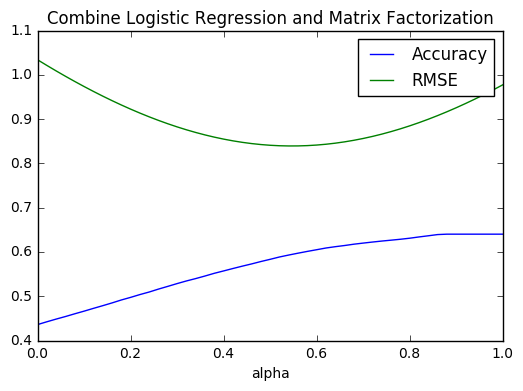

In [29]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(np.arange(0, 1.02, 0.02), accuracies, label='Accuracy')
plt.plot(np.arange(0, 1.02, 0.02), RMSEs, label='RMSE')
plt.xlabel('alpha')
plt.title('Combine Logistic Regression and Matrix Factorization')
plt.legend()
plt.show()

## Test Accuracy

In [30]:
alpha = optimalAlpha
trueRating_test = allratings[-N_test:]
trueRating_test.index = range(N_test)

clf_pred_test = logistic_clf.predict(wordvec5[-N_test:])
mf_pred_test = MF_pred_test.iloc[:,2]
prediction = clf_pred_test*alpha + mf_pred_test*(1-alpha)

accuracy = np.sum(trueRating_test == np.round(prediction))*1.0/N_test
print("Test accuracy is %.6f" % (accuracy))
    
RMSE = np.sqrt(np.sum((trueRating_test - prediction)**2)/N_test)
print("Test RMSE is", RMSE)

Test accuracy is 0.640621
('Test RMSE is', 0.91732649848954562)


# Conclusion

Logistic regression based on review (including summary) text is most effective to predict the class correctly (higher accuracy). While matrix factorization alone has worse accuracy and RMSE than logistic regression, combining matrix factorization prediction into logistic regression prediction can leads to a better RMSE score. 